# Visualize predictions

In [1]:
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt,
    ensure_folder, deterministic_everything,
)

import torch
import pytorch_lightning as pl

sys.path.append('..')
import common as com

from pytorch_model import Task2Baseline

param = com.yaml_load('config.yaml')
dirs = com.select_dirs(param=param, mode='development')

deterministic_everything(2020, pytorch=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2020-03-14 11:50:12,794 - INFO - load_directory <- development


In [2]:
class Task2Dataset(torch.utils.data.Dataset):
    def __init__(self, files, n_mels, frames, n_fft, hop_length, power, transform, cache_to=None):
        self.transform = transform
        self.files = files
        self.n_mels, self.frames, self.n_fft = n_mels, frames, n_fft
        self.hop_length, self.power = hop_length, power
        # load cache or convert all the data for the first time
        if cache_to is not None and Path(cache_to).exists():
            com.logger.info(f'Loading cached {cache_to}')
            self.X = np.load(cache_to)
        else:
            self.X = com.list_to_vector_array(self.files,
                             n_mels=self.n_mels,
                             frames=self.frames,
                             n_fft=self.n_fft,
                             hop_length=self.hop_length,
                             power=self.power)
            if cache_to is not None:
                np.save(cache_to, self.X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        x = self.transform(x)
        return x, x

In [3]:
class Task2(pl.LightningModule):

    def __init__(self, hparams, files):
        super().__init__()
        self.model = Task2Baseline()
        self.mseloss = torch.nn.MSELoss()
        self.hparams = hparams
        # split data files
        n_val = int(hparams.validation_split * len(files))
        self.val_files = random.sample(files, n_val)
        self.train_files = [f for f in files if f not in self.val_files]

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.mseloss(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.mseloss(y_hat, y)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr,
                                betas=(self.hparams.b1, self.hparams.b2),
                                weight_decay=self.hparams.weight_decay)

    def _get_dl(self, for_what):
        files = self.train_files if for_what == 'train' else self.val_files
        cache_file = f'{self.hparams.work_folder}/__cache_{str(files[0]).split("/")[-3]}_{for_what}.npy'
        ds = Task2Dataset(files,
                           n_mels=self.hparams.n_mels,
                           frames=self.hparams.frames,
                           n_fft=self.hparams.n_fft,
                           hop_length=self.hparams.hop_length,
                           power=self.hparams.power,
                           transform=com.ToTensor1d(device=device),
                           cache_to=cache_file)
        return torch.utils.data.DataLoader(ds, batch_size=self.hparams.batch_size,
                          shuffle=(self.hparams.shuffle if for_what == 'train' else False))

    def train_dataloader(self):
        return self._get_dl('train')

    def val_dataloader(self):
        return self._get_dl('val')


from argparse import Namespace

args = {
    'epochs': param['fit']['epochs'],
    'batch_size': param['fit']['batch_size'],
    'lr': 0.001,
    'b1': 0.9,
    'b2': 0.999,
    'weight_decay': 0.0,
    'shuffle': param['fit']['shuffle'],
    'n_mels': param["feature"]["n_mels"],
    'frames': param["feature"]["frames"],
    'n_fft': param["feature"]["n_fft"],
    'hop_length': param["feature"]["hop_length"],
    'power': param["feature"]["power"],
    'work_folder': param['model_directory'],
    'validation_split': param['fit']['validation_split'],
}
hparams = Namespace(**args)

for target_dir in dirs:
    target = str(target_dir).split('/')[-1]
    print(f'==== [{target}] with {torch.cuda.device_count()} GPU(s) ====')

    files = com.file_list_generator(target_dir)

    task2 = Task2(hparams, files)
    
    model_file = f'{param["model_directory"]}/model_{target}.pth'
    task2.model.load_state_dict(torch.load(model_file))
    task2.model = task2.model.to(device)

2020-03-14 11:50:42,049 - INFO - target_dir : /home/foo/dcase2020_task2_variants/dev_data/ToyCar
2020-03-14 11:50:42,056 - INFO - train_file num : 4000


==== [ToyCar] with 1 GPU(s) ====


## Visualize 

2020-03-14 11:51:05,951 - INFO - Loading cached ./model/__cache_ToyCar_val.npy


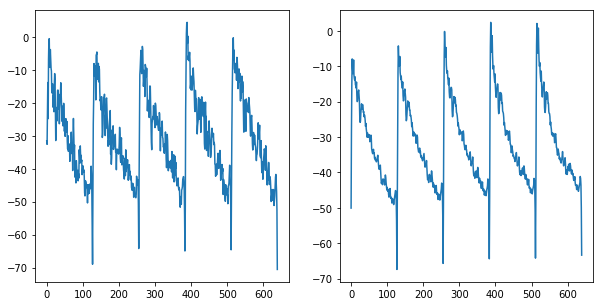

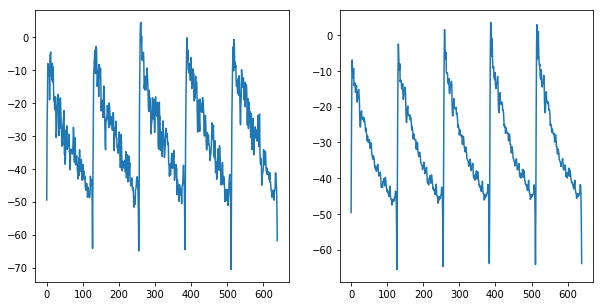

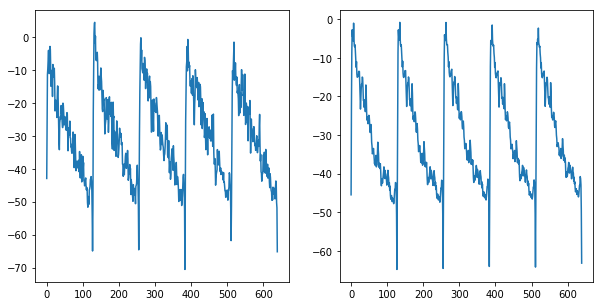

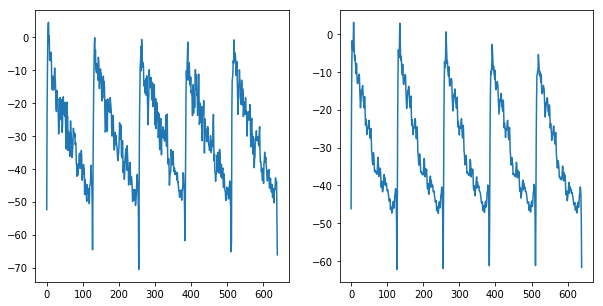

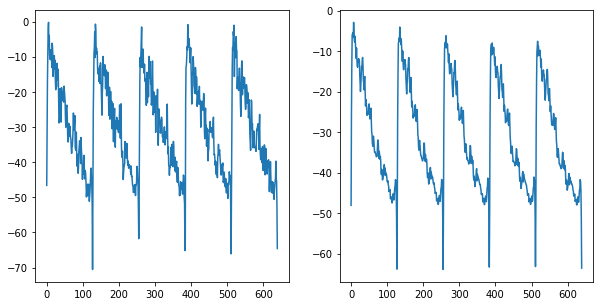

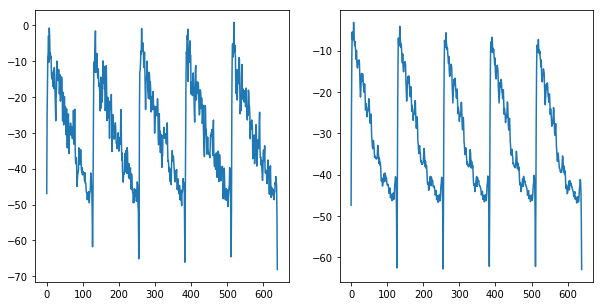

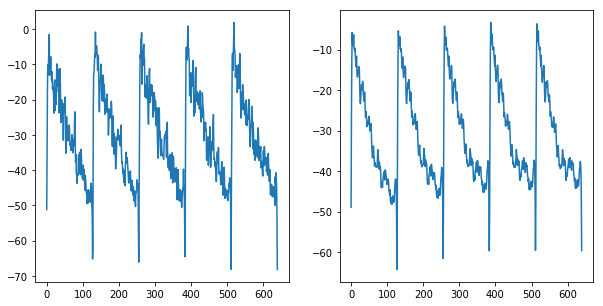

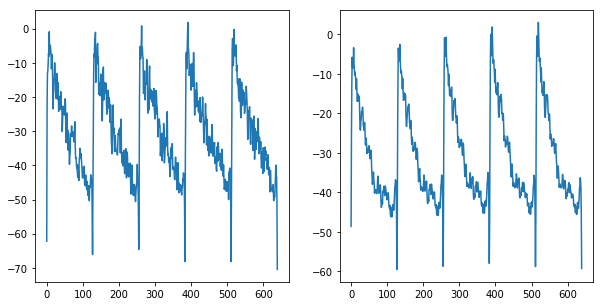

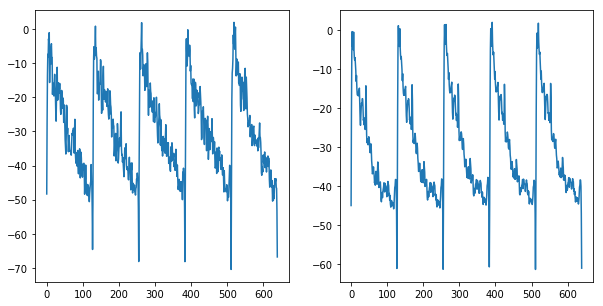

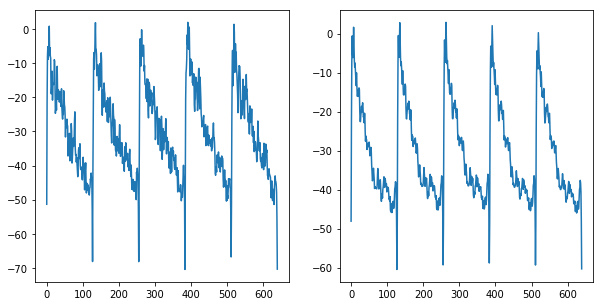

In [4]:
# Get one batch of samples from validation set, then get model prediction result.
dl = task2.val_dataloader()
x, y = next(iter(dl))
with torch.no_grad():
    yhat = task2.model(x)
# Show 
for i in range(10):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sample_idx = i
    axs[0].plot(x.cpu().numpy()[sample_idx][0]); axs[1].plot(yhat.cpu().numpy()[sample_idx][0]);